<a href="https://colab.research.google.com/github/fds787896/KagglePractice/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###前情提要:此Code必沒有按照Design Pattern去撰寫,Scope皆使用Gobal Variables。
#因為在資料的處理方面,並無重複的步驟,因此放棄使用Static與Object的概念
#此外,因為步驟並無重複性,且變數的運用有連續性,故若使用Design Pattern撰寫,並不會讓程式碼的可讀性增加,本篇code亦無擴展性的需求
#基於上述理由,放棄使用Design Pattern的撰寫模式

In [ ]:
#掛載google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#轉至執行資料目錄
%cd drive/MyDrive/Titanic/

/content/drive/MyDrive/Titanic


In [ ]:
#載入所需Packages
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve
import pickle

In [ ]:
#讀取train還有test檔案
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
combine = [train_df,test_df]

In [ ]:
#瀏覽資料樣貌
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#確認每個欄位的資料型態
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
#確認一下各欄位是否具有Nan值
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
#查看Catogorical的相關資訊(其主要是看"值域"會不會"太廣"",如果值域太廣,勢必要對feature做一些處理,不然大部分模型對其預測效果皆會降低)
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Butt, Major. Archibald Willingham",male,1601,G6,S
freq,1,577,7,4,644


In [ ]:
#Pclass看官方文檔屬於類別資料,所以也要看一下他的值域
train_df["Pclass"].unique()

array([3, 1, 2])

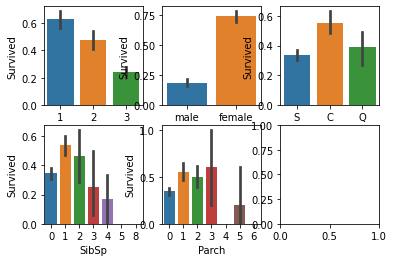

In [ ]:
#資料觀察,第一步看Categorical Data對Survived的影響(Pclass,Sex,Embarked)
fig, ax = plt.subplots(nrows = 2,ncols = 3)
sns.barplot(x = "Pclass",y = "Survived", data = train_df,ax = ax[0,0])
sns.barplot(x = "Sex",y = "Survived", data = train_df, ax = ax[0,1])
sns.barplot(x = "Embarked",y = "Survived", data = train_df,ax = ax[0,2])
sns.barplot(x = "SibSp",y = "Survived", data = train_df,ax = ax[1,0])
sns.barplot(x = "Parch",y = "Survived", data = train_df,ax = ax[1,1])
#從數據初步研判,Pclass中,1等票的人有較高的存活率,女性比男性有更高的存活率,C碼頭的人存活率較高
#兄弟姊妹較多在船上存活率較低,父母及親戚數量則無明顯趨勢

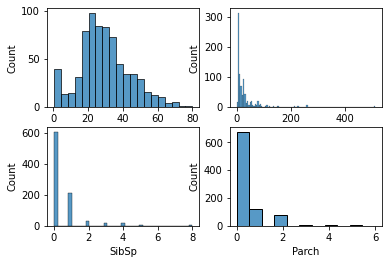

In [ ]:
#資料觀察,觀察continuous的資料分佈狀態(Age,Fare,SibSp,Parch)
fig,ax = plt.subplots(2,2)
sns.histplot(data = train_df,x = "Age",ax = ax[0,0])
sns.histplot(data = train_df,x = "Fare",ax = ax[0,1])
sns.histplot(data = train_df,x = "SibSp",ax = ax[1,0])
sns.histplot(data = train_df,x = "Parch",ax = ax[1,1])
#從上述狀態來看,不管是連續型隨機變數還是離散型隨機變數,其分佈都不成常態分佈,所以在觀察與Survived的相關係數時,不能使用Peason correlation
#應該使用Spearman可以避免極值與分佈不均的影響

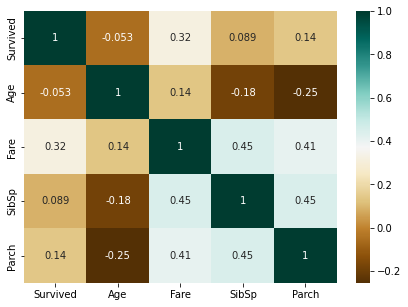

In [ ]:
#資料觀察,第二步看Numerical Data對Survived的線性關係
corr = train_df[["Survived","Age","Fare","SibSp","Parch"]].corr(method = "spearman")
plt.figure(figsize = (7,5))
g = sns.heatmap(corr, cmap = 'BrBG', annot = True)
#從結果來觀察,似乎沒有什麼單一因素對生存率有決定性的影響,在統計意義上來講,就是沒有一項相關係數大於0.5)
#故應該考量兩個甚至更多個因素交替作用下對Survived造成的影響。
#但因為主要是以建模為主,故直接進行資料預處理,之後直接進入挑選模型,不在多做視覺化分析

In [ ]:
#可以drop兩個features:tickets,cabin,因為tickets有太多重複值(太多重複值代表此項資訊可能不實,參考價值較低);cabin是因為太多Nan值(如果自己硬填,等於是猜測,會影響模型)
train_df = train_df.drop(["Ticket","Cabin","PassengerId"],axis = 1)
test_df = test_df.drop(["Ticket","Cabin"],axis = 1)

In [ ]:
#填補缺失值(這邊直接用mode填入的原因為缺失資料較少,用眾數代表性較佳)
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].dropna().median())

In [ ]:
#將Sex轉為1跟0
train_df["Sex"] = train_df["Sex"].map({"male":1,"female":0})
test_df["Sex"] = test_df["Sex"].map({"male":1,"female":0})

In [ ]:
#將Name中的稱謂提取出來
train_title = train_df["Name"].map(lambda x :x.split(",")[1].split(".")[0].replace(" ",""))
test_title = test_df["Name"].map(lambda x :x.split(",")[1].split(".")[0].replace(" ",""))

In [ ]:
#統計稱謂出現的次數
collections.Counter(train_title_v1.tolist())

In [ ]:
#將稱謂做簡單分組
train_title = [i if i == "Mr" or i == "Mrs" or i == "Miss" or i == "Master" else "other" for i in train_title]
test_title = [i if i == "Mr" or i == "Mrs" or i == "Miss" or i == "Master" else "other" for i in test_title]

In [ ]:
#將稱謂成為train_df的特徵
train_df["Title"] = train_title
test_df["Title"] = test_title

In [ ]:
#drop掉name這個特徵
train_df = train_df.drop(["Name"],axis = 1)
test_df = test_df.drop(["Name"],axis = 1)

In [ ]:
#將Categorical feature轉換為dummy variavles(此組為訓練線性模型,故需要一組參照組,故需要drop一個虛擬變量)
Embarked_dummy = pd.get_dummies(train_df["Embarked"],drop_first = True)
Title_dummy = pd.get_dummies(train_df["Title"],drop_first = True)
Pclass_dummy = pd.get_dummies(train_df["Pclass"],drop_first = True)
Embarked_dummy_test = pd.get_dummies(test_df["Embarked"],drop_first = True)
Title_dummy_test = pd.get_dummies(test_df["Title"],drop_first = True)
Pclass_dummy_test = pd.get_dummies(test_df["Pclass"],drop_first = True)

In [ ]:
#線性模型需要加入啞變量並將原本的變量丟drop
train_df_1 = pd.concat([train_df,Embarked_dummy,Title_dummy,Pclass_dummy],axis = 1)
test_df_1 = pd.concat([test_df,Embarked_dummy_test,Title_dummy_test,Pclass_dummy_test],axis = 1)
train_df_1 = train_df_1.drop(["Embarked","Title","Pclass"],axis = 1)
test_df_1 = test_df_1.drop(["Embarked","Title","Pclass"],axis = 1)

In [ ]:
#填補Age的na值
train_copy = train_df_1.copy()
imp = IterativeImputer(random_state=0)
tmp_df = imp.fit_transform(train_copy)
newAge = tmp_df[:,3]

test_copy = test_df_1.copy()
tmp_test = imp.fit_transform(test_copy)
newAgeTest = tmp_test[:,2]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
#將新的Age feature加入train_df並將舊的age drop
train_df["newAge"] = pd.Series(newAge)
train_df_1["newAge"] = pd.Series(newAge)
test_df["newAge"] = pd.Series(newAge)
test_df_1["newAge"] = pd.Series(newAge)

train_df = train_df.drop(["Age"],axis = 1)
train_df_1 = train_df_1.drop(["Age"],axis = 1)
test_df = test_df.drop(["Age"],axis = 1)
test_df_1 = test_df_1.drop(["Age"],axis = 1)

In [ ]:
#標準化連續型數值資料
train_df[["Fare","newAge"]] = StandardScaler().fit_transform(train_df[["Fare", "newAge"]])
train_df_1[["Fare","newAge"]] = StandardScaler().fit_transform(train_df_1[["Fare", "newAge"]])
test_df[["Fare","newAge"]] = StandardScaler().fit_transform(test_df[["Fare","newAge"]])
test_df_1[["Fare","newAge"]] = StandardScaler().fit_transform(test_df_1[["Fare","newAge"]])

In [ ]:
#把父母小孩跟兄弟姊妹這兩個相似特徵結合為一個特徵(combine the parch and sibsp)
train_df["familySize"] = train_df["Parch"] + train_df["SibSp"]
train_df_1["familySize"] = train_df_1["Parch"] + train_df_1["SibSp"]
test_df["familySize"] = test_df["Parch"] + test_df["SibSp"]
test_df_1["familySize"] = test_df_1["Parch"] + test_df_1["SibSp"]

In [ ]:
#創造一個新的特徵,是否有家人,因為familySize這個特徵屬於離散型數值資料,不能將其標準化,如果直接做hot encoding這樣會製造太多啞變量
#有可能會導致模型的bias或是拉長找到最小損失函數的時間
train_df["Alone"] = pd.Series([1 if i > 0 else 0 for i in train_df["familySize"]])
train_df_1["Alone"] = pd.Series([1 if i > 0 else 0 for i in train_df_1["familySize"]])
test_df["Alone"] = pd.Series([1 if i > 0 else 0 for i in test_df["familySize"]])
test_df_1["Alone"] = pd.Series([1 if i > 0 else 0 for i in test_df_1["familySize"]])

In [ ]:
#把parch,sibsp,familySize這三個特徵drop掉
train_df = train_df.drop(["Parch","SibSp","familySize"],axis = 1)
train_df_1 = train_df_1.drop(["Parch","SibSp","familySize"],axis = 1)
test_df = test_df.drop(["Parch","SibSp","familySize"],axis = 1)
test_df_1 = test_df_1.drop(["Parch","SibSp","familySize"],axis = 1)

In [ ]:
#非線性組,需要將categorical data值域轉為數值
train_df["Embarked"] = train_df["Embarked"].map({"S":0,"C":1,"Q":2})
train_df["Title"] = train_df["Title"].map({"Mr":0,"Mrs":1,"Miss":2,"Master":3,"other":4})
test_df["Embarked"] = test_df["Embarked"].map({"S":0,"C":1,"Q":2})
test_df["Title"] = test_df["Title"].map({"Mr":0,"Mrs":1,"Miss":2,"Master":3,"other":4})

In [ ]:
#開始建模,把資料分成訓練資料及預測資料
#線性組
X_train_1 = train_df_1.drop("Survived", axis=1)
Y_train = train_df_1["Survived"]
X_test_1  = test_df_1.drop(["PassengerId"],axis = 1).copy()

#非線性組
X_train = train_df.drop("Survived",axis = 1)
X_test = test_df.drop(["PassengerId"],axis = 1)

#設置cross validation的條件,下面每個模型的隨機種子都必須設置為0,避免每次訓練出來的acc不一致
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
X_train.shape,X_test.shape

((891, 7), (418, 7))

In [ ]:
# Logistic Regression(Linear)
logreg = LogisticRegression(random_state = 0)
score = cross_val_score(logreg, X_train_1, Y_train, cv=k_fold, n_jobs=-1, scoring='accuracy')
score.mean()*100

81.70536828963796

In [ ]:
# Support Vector Machines(Linear)
svc = SVC(random_state = 0)
score = cross_val_score(svc,X_train_1,Y_train,cv=k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

81.59300873907614

In [ ]:
#KNN(non-Linear)
knn = KNeighborsClassifier(n_neighbors = 3)
score = cross_val_score(knn,X_train,Y_train,cv=k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

80.35830212234707

In [ ]:
# Gaussian Naive Bayes(non-Linear)
gaussian = GaussianNB()
score = cross_val_score(gaussian,X_train,Y_train,cv=k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

79.01373283395756

In [ ]:
# Perceptron(Linear)
perceptron = Perceptron(random_state = 0)
score = cross_val_score(perceptron,X_train_1,Y_train,cv=k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

74.74157303370787

In [ ]:
# Linear SVC(Linear)
linear_svc = LinearSVC(random_state = 0)
score = cross_val_score(linear_svc,X_train_1,Y_train,cv=k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

82.48938826466917

In [ ]:
# Stochastic Gradient Descent(Linear)
sgd = SGDClassifier(random_state = 0)
score = cross_val_score(sgd,X_train_1,Y_train,cv=k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

79.12359550561798

In [ ]:
# Decision Tree(non-Linear)
decision_tree = DecisionTreeClassifier(random_state = 0)
score = cross_val_score(decision_tree,X_train,Y_train,cv=k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

81.374531835206

In [ ]:
# Random Forest(non-Linear)
random_forest = RandomForestClassifier(n_estimators=100,random_state = 0)
score = cross_val_score(random_forest,X_train,Y_train,cv=k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

81.4769038701623

In [ ]:
#GradientBoostingClassifier
GBC = GradientBoostingClassifier(random_state = 0)
score = cross_val_score(GBC,X_train,Y_train,cv = k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

82.71660424469414

In [ ]:
#XGBoost
XGB = XGBClassifier(random_state = 0)
score = cross_val_score(XGB,X_train,Y_train,cv = k_fold,n_jobs = -1,scoring = "accuracy")
score.mean()*100

81.25842696629213

In [ ]:
#看起來GBC對模型預測能力最佳,所以針對GBC進行調參
#先用random search 方法找到一個可能最佳解的範圍
random_search = {"learning_rate":np.linspace(0.01,0.5,50),
        "n_estimators":[i for i in range(50,1001,50)],
         "max_depth":[i for i in range(1,201,10)],
         "min_samples_split":np.linspace(0.1, 1.0, 10, endpoint=True),
         "min_samples_leaf":np.linspace(0.1, 0.5, 5,endpoint=True),
         "max_features":[i for i in range(1,X_train.shape[1]+1)]}

Random_GBC = RandomizedSearchCV(estimator = GBC, param_distributions = random_search, n_iter = 100,
cv = 10, verbose=2, random_state=0, n_jobs = -1)
Random_GBC.fit(X_train,Y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0...
                                        'max_depth': [1, 11, 21, 31, 41, 51, 61,
                                                      71, 81, 91, 101, 111, 121,
                                                      131, 141, 151, 161, 171,
                                                      181, 191],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'min_samples_spli

In [ ]:
#觀察最佳解的參數,將利用這些參數來縮小範圍找到critical point
bestParameter = Random_GBC.best_params_
bestParameter = {'learning_rate': [0.39],
 'max_depth': [61],
 'max_features': [4],
 'min_samples_leaf': [0.1],
 'min_samples_split': [0.2],
 'n_estimators': [250]}

In [ ]:
#制定grid parameter的範圍
grid_search = {"learning_rate":np.linspace(0.19,0.59,41),
        "n_estimators": [int(i)for i in np.linspace(230,270,41)],
         "max_depth": [int(i)for i in np.linspace(41,81,41)],
         "min_samples_split":np.linspace(0.1,0.3,21),
         "min_samples_leaf":np.linspace(0.05,0.15,11),
         "max_features": [int(i)for i in np.linspace(3,5,3)]}

In [ ]:
#用grid search找尋最佳參數
for key,value in grid_search.items():
  bestParameter[key] = value
  Grid_GBC = GridSearchCV(estimator = GBC, param_grid = bestParameter,cv = 10, verbose=2, n_jobs = -1)
  Grid_GBC.fit(X_train,Y_train)
  for key,value in Grid_GBC.best_params_.items():
   Grid_GBC.best_params_[key] = [value]
  bestParameter = Grid_GBC.best_params_
Grid_GBC.best_params_

Fitting 10 folds for each of 41 candidates, totalling 410 fits
Fitting 10 folds for each of 41 candidates, totalling 410 fits
Fitting 10 folds for each of 41 candidates, totalling 410 fits
Fitting 10 folds for each of 21 candidates, totalling 210 fits
Fitting 10 folds for each of 11 candidates, totalling 110 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits


{'learning_rate': [0.59],
 'max_depth': [41],
 'max_features': [4],
 'min_samples_leaf': [0.09999999999999999],
 'min_samples_split': [0.1],
 'n_estimators': [255]}

In [ ]:
#查看最佳參數訓練出來的分數
Grid_GBC.score(X_train,Y_train)

0.8967452300785634

In [ ]:
#把預測結果做成df並存成csv檔案
Prediction = Grid_GBC.predict(X_test)
submission = pd.DataFrame({"PassengerId":test_df["PassengerId"],"Survived":Prediction})
submission.to_csv("submission.csv",index = False)

In [ ]:
#保存模型
file_name = "Grid_GBC.pkl"

# save
pickle.dump(Grid_GBC, open(file_name, "wb"))

# load
Grid_GBC_loaded = pickle.load(open(file_name, "rb"))